In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import ipywidgets as widgets
# from IPython.display import display

##### Load & Process Data

In [2]:
def load_gold_data(file, scoring_function):
    df = pd.read_csv(file, skiprows=5, sep="\s+", index_col=False, quotechar="'")
    
    # drop NaN columns
    df.drop(columns=["Ligand", "name.1"], inplace=True)
    
    # drop leading dot and backslash from the file name
    df["File"] = df["File"].str.replace(r'^\.\x5C', '', regex=True)
    
    # drop columns based on scoring function
    scoring_columns = {
        "chemplp": ["S(PLP)", "S(hbond)", "S(cho)", "S(metal)", "DE(clash)", "DE(tors)", "intcor", "time", "File"],
        "asp": ["ASP", "S(Map)", "DE(clash)", "DE(int)", "intcor", "time", "File"],
        "chemscore": ["DG", "S(hbond)", "S(metal)", "S(lipo)", "H(rot)", "DE(clash)", "DE(int)", "intcor", "time", "File"],
        "goldscore": ["S(hb_ext)", "S(vdw_ext)", "S(hb_int)", "S(int)", "intcor", "time", "File"]
    }
    
    if scoring_function in scoring_columns:
        df.drop(columns=scoring_columns[scoring_function], inplace=True)
        
    # goldscore has a 'Fitness' column instead of 'Score'
    if scoring_function == "goldscore":
        df.rename(columns={"Fitness": "Score"}, inplace=True)
    
    # set ligand name as the index to facilitate merging
    df.set_index("name", inplace=True)
    
    return df

def load_vina_data(file):
    df = pd.read_csv(file, skiprows=2, names=["name", "Score"], sep=":")
    df["name"] = df["name"].str.replace("_out.pdbqt", "", regex=False)
    
    # set ligand name as the index to facilitate merging
    df.set_index("name", inplace=True)

    return df



<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_7069/3837905522.py:2: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, skiprows=5, sep="\s+", index_col=False, quotechar="'")


In [3]:
def merge_all_clusters():
    merged_df = pd.DataFrame()


    for cluster_number in range(1, 6):  
        cluster_chemplp = load_gold_data(file=f"cluster{cluster_number}_chemplp.lst", scoring_function="chemplp")
        cluster_asp = load_gold_data(file=f"cluster{cluster_number}_asp.lst", scoring_function="asp")
        cluster_chemscore = load_gold_data(file=f"cluster{cluster_number}_chemscore.lst", scoring_function="chemscore")
        cluster_goldscore = load_gold_data(file=f"cluster{cluster_number}_goldscore.lst", scoring_function="goldscore")
        cluster_vina = load_vina_data(file=f"cluster{cluster_number}_vina.txt")
        cluster_vinardo = load_vina_data(file=f"cluster{cluster_number}_vinardo.txt")

        # rename columns to indicate cluster and scoring function
        cluster_chemplp.columns = [f"cluster{cluster_number}_chemplp"]
        cluster_asp.columns = [f"cluster{cluster_number}_asp"]
        cluster_chemscore.columns = [f"cluster{cluster_number}_chemscore"]
        cluster_goldscore.columns = [f"cluster{cluster_number}_goldscore"]
        cluster_vina.columns = [f"cluster{cluster_number}_vina"]
        cluster_vinardo.columns = [f"cluster{cluster_number}_vinardo"]

        # concatenate horizontally to a single dataframe
        merged_df = pd.concat([merged_df, cluster_chemplp, cluster_asp, cluster_chemscore,
                                cluster_goldscore, cluster_vina, cluster_vinardo], axis=1)

    return merged_df


In [4]:
# merge clusters into a single dataframe
merged_df = merge_all_clusters()

---

##### Get & Apply Thresholds

In [5]:
def get_thresholds(threshold_value):
    thresholds = {}
    for cluster in clusters:
        max_columns = [f"{cluster}_{suffix}" for suffix in max_columns_suffixes]
        min_columns = [f"{cluster}_{suffix}" for suffix in min_columns_suffixes]

        max_scores = merged_df[max_columns].max()
        min_scores = merged_df[min_columns].min()

        for col in max_columns:
            thresholds[col] = max_scores[col] * threshold_value 

        for col in min_columns:
            thresholds[col] = min_scores[col] * threshold_value
            
    return thresholds


def apply_thresholds(df, thresholds):
    result_df = df.copy()
    
    for column, threshold in thresholds.items():
        if column.endswith(("chemplp", "asp", "chemscore", "goldscore")):
            result_df[column] = (df[column] > threshold).astype(int)
        elif column.endswith(("vina", "vinardo")):
            result_df[column] = (df[column] < threshold).astype(int)
            
    result_df['ligand_vote_count'] = result_df.sum(axis=1)
    sorted_df = result_df.sort_values(by="ligand_vote_count", ascending=False)
    
    return sorted_df

In [6]:
th_df = merged_df.copy()
clusters = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']
max_columns_suffixes = ['chemplp', 'asp', 'chemscore', 'goldscore']
min_columns_suffixes = ['vina', 'vinardo']

THRESHOLD_VALUE = 0.8

thresholds = get_thresholds(THRESHOLD_VALUE)
votes_df = apply_thresholds(th_df, thresholds)

In [7]:
votes_df

,cluster1_chemplp,cluster1_asp,cluster1_chemscore,cluster1_goldscore,cluster1_vina,cluster1_vinardo,cluster2_chemplp,cluster2_asp,cluster2_chemscore,cluster2_goldscore,...,cluster4_goldscore,cluster4_vina,cluster4_vinardo,cluster5_chemplp,cluster5_asp,cluster5_chemscore,cluster5_goldscore,cluster5_vina,cluster5_vinardo,ligand_vote_count
name,,,,,,,,,,,,,,,,,,,,,
Z1095037182,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,26
Z1038857662,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,26
Z971000154,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,0,1,1,25
Z1562881124,1,0,1,1,1,1,1,0,1,1,...,0,1,0,1,1,1,1,1,1,22
Z971082818,0,1,1,0,1,1,0,1,1,1,...,1,1,0,1,1,1,0,1,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z2964721849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Z1128049585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Z1497149823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
sorted_vote_count = votes_df["ligand_vote_count"].reset_index()
sorted_vote_count

,name,ligand_vote_count
0,Z1095037182,26
1,Z1038857662,26
2,Z971000154,25
3,Z1562881124,22
4,Z971082818,21
...,...,...
10234,Z2964721849,0
10235,Z1128049585,0
10236,Z1497149823,0
10237,Z2181612190,0


In [9]:
vote_frequencies = sorted_vote_count['ligand_vote_count'].value_counts().sort_index()
vote_frequencies = vote_frequencies.reset_index()
vote_frequencies.columns = ['votes', 'frequency']

In [10]:
# merged_df.to_csv("outputs/merged_df.csv", index=True)
with pd.ExcelWriter("outputs/processed_docking_data.xlsx") as writer:
    merged_df.to_excel(writer, sheet_name="Merged Data", index=True)
    votes_df.to_excel(writer, sheet_name="votes_df", index=True)
    sorted_vote_count.to_excel(writer, sheet_name="Sorted Vote Counts", index=False)
    vote_frequencies.to_excel(writer, sheet_name="Vote Frequencies", index=False)

---

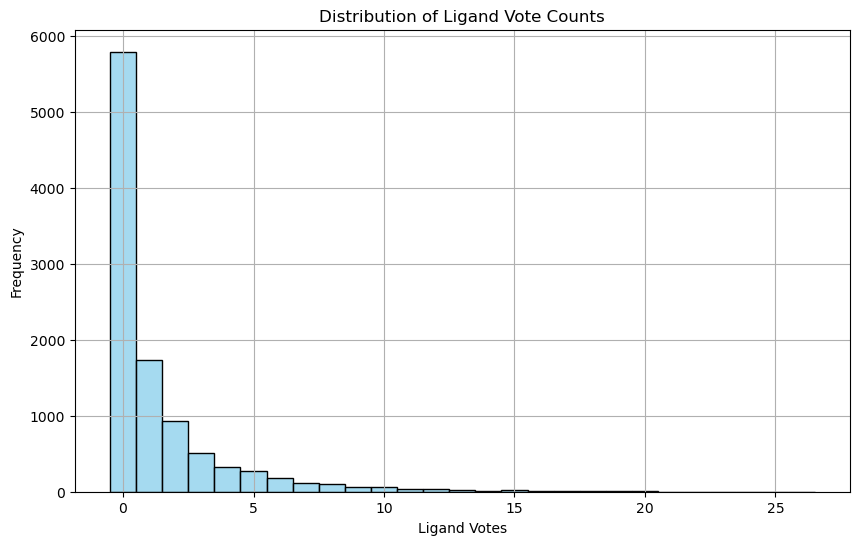

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(sorted_vote_count["ligand_vote_count"], bins=range(0, 6), discrete=True, color="skyblue")
plt.title("Distribution of Ligand Vote Counts")
plt.xlabel("Ligand Votes")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [12]:
print(thresholds)

{'cluster1_chemplp': 69.104, 'cluster1_asp': 37.2, 'cluster1_chemscore': 32.528, 'cluster1_goldscore': 64.792, 'cluster1_vina': -8.152, 'cluster1_vinardo': -5.8552, 'cluster2_chemplp': 64.352, 'cluster2_asp': 40.19200000000001, 'cluster2_chemscore': 31.312, 'cluster2_goldscore': 65.056, 'cluster2_vina': -7.9224000000000006, 'cluster2_vinardo': -6.3688, 'cluster3_chemplp': 67.16799999999999, 'cluster3_asp': 37.888, 'cluster3_chemscore': 31.28, 'cluster3_goldscore': 69.096, 'cluster3_vina': -8.294400000000001, 'cluster3_vinardo': -6.0976, 'cluster4_chemplp': 59.776, 'cluster4_asp': 35.0, 'cluster4_chemscore': 30.936000000000003, 'cluster4_goldscore': 58.976, 'cluster4_vina': -8.164, 'cluster4_vinardo': -6.645600000000001, 'cluster5_chemplp': 65.784, 'cluster5_asp': 38.56, 'cluster5_chemscore': 29.960000000000004, 'cluster5_goldscore': 65.048, 'cluster5_vina': -8.2904, 'cluster5_vinardo': -5.9592}
